In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit
import h5py
from IPython.display import Image
from sklearn.decomposition import PCA, TruncatedSVD, SparseCoder, NMF
from sklearn.decomposition import MiniBatchDictionaryLearning, KernelPCA
import random
import pandas as pd
import pickle
from matplotlib.ticker import StrMethodFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

/home/fernando/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def gauss2 (x,a,mu,sigma,a2,mu2,sigma2):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2)) + a2*np.exp(-(x - mu2)**2 / (2 * sigma2**2))

def gaussiana(x,a,mu,sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

def snr(x):
    return (np.mean(x))/(np.std(x))

def red(noise,lenght=144000):
    output = np.ones(lenght)
    for i in range(lenght - 1):
        output[i]=(0.5 * (noise[i] + noise[i+1]))
    return output

def genruidorojo(noise,lenght=144000): 
    x=genruido(noise,lenght)
    x2=red(x,lenght)
    x=(x+x2)
    x=x/np.mean(x)
    snr2=snr(x)
    x=x-1
    x=x*(1/(noise/snr2))
    x=x+1
    return x
    
def genruido(noise,lenght=144000): 
    a=2862.316781326982 
    mu=0.9976487554779495 
    sigma=0.1018979580252512 #+0.02
    a2=5417.280508101456 
    mu2=0.9932463577214291 
    sigma2=-0.040626701263867235 #-0.02
    x=np.linspace(0.1,2,lenght)
    y=gauss2(x,a,mu,sigma,a2,mu2,sigma2)
    C = np.cumsum(y)
    Cnorm=C/np.max(C)
    Cinv = interpolate.interp1d(Cnorm,x)
    s = np.random.uniform(0,1,lenght)
    ruido=Cinv(s)
    snr2=snr(ruido)
    ruido=ruido-1
    ruido=ruido*(1/(noise/snr2))
    ruido=ruido+1
    return ruido   

def outliers(x):
    size=x.shape[0]
    std=np.std(x)
    mean=np.mean(x)
    tt = np.where(np.abs(x-mean) > std*5)[0]
    for i in tt:
        x[i]=(x[i+1]+x[i-1])/2
    return x

def prom_mov(x,mov):
	size=x.shape[0]
	x_mov=np.zeros(size-mov)
	for i in range(size-mov):
		x_mov[i]=np.sum(x[i:i+mov])/mov
	return x_mov

def med_mov(x,mov):
	size=x.shape[0]
	x_mov=np.zeros(size-mov)
	for i in range(size-mov):
		x_mov[i]=np.median(x[i:i+mov])
	return x_mov


def tiempo(x,freq=20):
	size=x.shape[0]
	t=size/(freq*60)
	return np.linspace(0,t,size)

def dexp(x,base,a,b,a2,b2):
    expo=np.zeros(len(x))
    for i in range(len(x)):
        if x[i]>= 0:
            expo[i]=base+a*np.exp(-x[i]/b)+a2*np.exp(-x[i]/b2)
        else:
            expo[i]=base+a*np.exp(x[i]/b)+a2*np.exp(x[i]/b2)
    return expo
            
    
def ruido_real2(noise,base,a,b,a2,b2,lenght=144000):
    ruido=genruidorojo(noise,lenght)
    freq_ruido = np.fft.fftfreq(lenght,d=0.05)
    fft_ruido=np.fft.fft(ruido)
    expo=dexp(freq_ruido,base,a,b,a2,b2)
    ruido=np.fft.ifft(fft_ruido.real*expo)
    ruido=ruido.real/np.mean(ruido.real)
    snr2=snr(ruido)
    ruido=ruido-1    
    ruido=ruido*(1/(noise/snr2))
    ruido=ruido+1
    return ruido
    
def ruido_real(noise,base,a,b,a2,b2,lenght=144000):
    ruido=genruido(noise,lenght)
    freq_ruido = np.fft.fftfreq(lenght,d=0.05)
    fft_ruido=np.fft.fft(ruido)
    expo=dexp(freq_ruido,base,a,b,a2,b2)
    ruido=np.fft.ifft(fft_ruido.real*expo)
    ruido=ruido.real/np.mean(ruido.real)
    snr2=(np.mean(ruido))/(np.std(ruido))
    ruido=ruido-1    
    ruido=ruido*(1/(noise/snr2))
    ruido=ruido+1
    return ruido

def fourierfilter(x,cutfreq):
	size=x.shape[0]
	freq = np.fft.fftfreq(size,d=0.05)
	x_fft=np.fft.fft(x)
	mask = np.abs(freq) > cutfreq
	x_fft[mask]=0
	x_fft=np.fft.ifft(x_fft)
	return x_fft

def pca_train(data_train):
    svd = TruncatedSVD(n_components=15, n_iter=7,random_state=45,tol=0)
    svd.fit(data_train.T)
    comp=svd.components_
    return comp

def pca_filter(data_noised,comp):
    ec_n=np.dot(comp,data_noised)  
    return np.dot(ec_n.T,comp)

def medio_trapezoid(x,depth,down,tc):
    y = np.zeros(len(x))
    a = ((depth-1)/(tc))
    y[:int(down)]=depth
    y[int(down):int(tc+down)] =  -a*(x[int(down):int(tc+down)]-tc-down) + 1
    y[int(tc+down):]=1
    return y

def medio_trapezoid2(x,depth,down,tc,arriba):
    y = np.zeros(len(x))
    a = ((depth-1)/(tc))
    y[:int(down)]=depth
    y[int(down):int(tc+down)] =  -a*(x[int(down):int(tc+down)]-tc-down) + arriba
    y[int(tc+down):]=arriba
    return y

In [4]:
lcx3=np.loadtxt('../data/hatp37_7ago.out');#### HATP37B CON TRANSITO DEL 7 DE AGOSTO 2016 IXON
lcx4=np.loadtxt('../data/transitohat37.out');   ###TRANSITO SIMULADO PARA HATP37B

In [5]:
size=144000
size1=lcx3.shape[0]
size3=lcx4.shape[0]


lcx_1=lcx3[10000:154000]
lcx_2=lcx3[size1-144000:size1]
transito_1=lcx4[10000:154000]
transito_2=lcx4[size3-144000:size3]

########################acomodando transito
shift=15000
transito1=np.zeros(size)
transito1[:]=transito1[:]+1

for i in range(size-shift):
	transito1[i+shift]=transito_1[i]

transito_1=transito1

shift=22000
transito2=np.zeros(size)
transito2[:]=transito2[:]+1
for i in range(size-shift):
	transito2[i]=transito_2[i+shift]

transito_2=transito2



In [6]:
x=tiempo(lcx_1)

(0, 120)

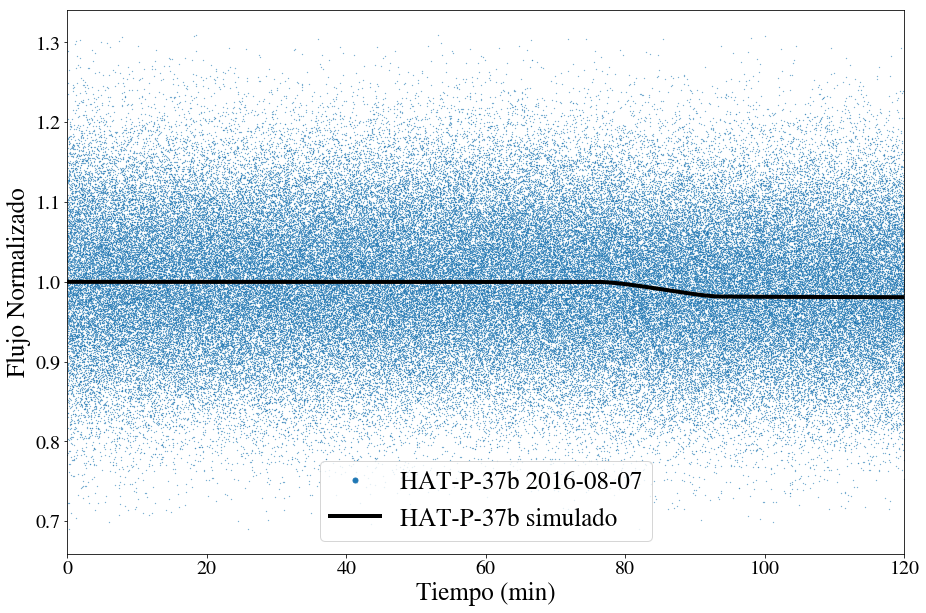

In [7]:
plt.figure(figsize=(15,10))
plt.plot(x,lcx_1,'.',markersize=0.5,label='HAT-P-37b 2016-08-07')
plt.plot(x,transito_1,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=25)
plt.ylabel('Flujo Normalizado',size=25)
plt.xticks(size=20)
plt.yticks(size=20)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
    
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_sinfil_1.png',dpi=300)

In [15]:
fft_transito=np.fft.fft(ruido_r)
############TRANSFORMADA DE FOURIER DE LA CURVA DE LUZ
freq = np.fft.fftfreq(size,d=0.05)
fft_lc=np.fft.fft(lc)

NameError: name 'ruido_r' is not defined

(0, 120)

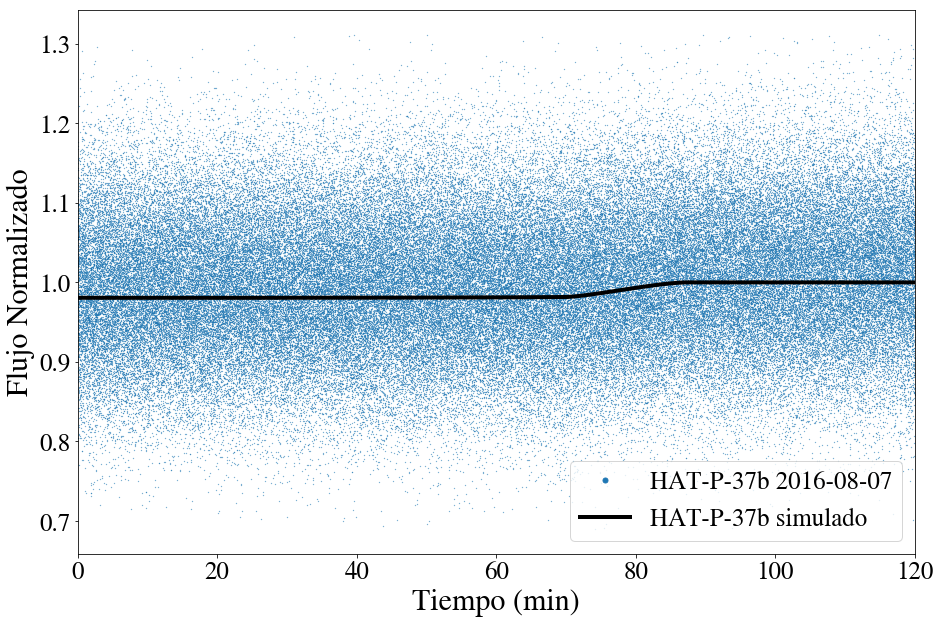

In [9]:
plt.figure(figsize=(15,10))
plt.plot(x,lcx_2,'.',markersize=0.5,label='HAT-P-37b 2016-08-07')
plt.plot(x,transito_2,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=30)
plt.ylabel('Flujo Normalizado',size=30)
plt.xticks(size=25)
plt.yticks(size=25)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_sinfil_2.png',dpi=300)

In [10]:
mov=3000
lcx_1_add=med_mov(lcx_1,mov)
lcx_2_add=med_mov(lcx_2,mov)
transito_1_add=med_mov(transito1,mov)
transito_2_add=med_mov(transito2,mov)


In [11]:
x_add=np.linspace(0,120,len(lcx_2_add))

(0, 120)

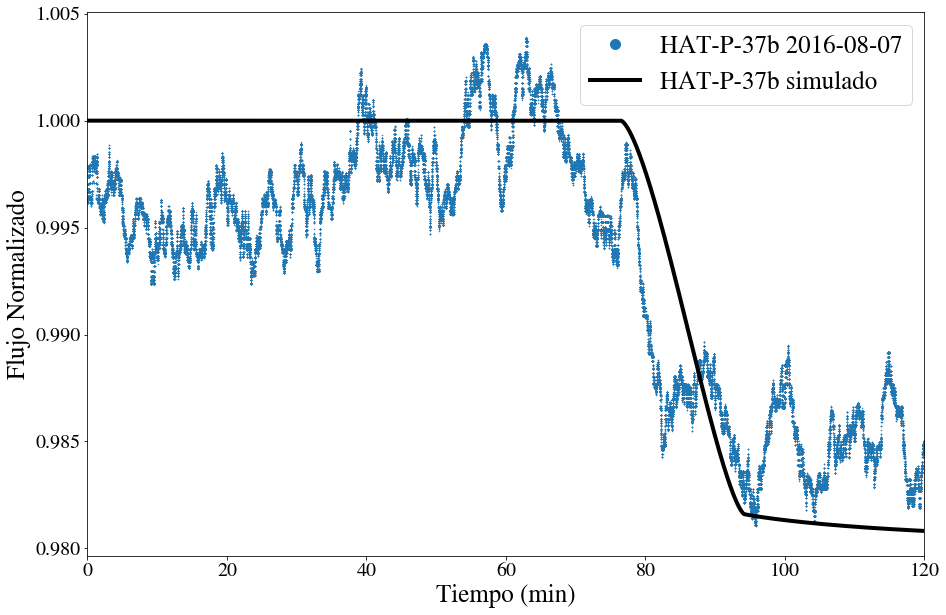

In [12]:
plt.figure(figsize=(15,10))
plt.plot(x_add,lcx_1_add-0.005,'o',markersize=0.5,label='HAT-P-37b 2016-08-07')
plt.plot(x_add,transito_1_add,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=25)
plt.ylabel('Flujo Normalizado',size=25)
plt.xticks(size=20)
plt.yticks(size=20)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_mov_1.png',dpi=300)

(0, 120)

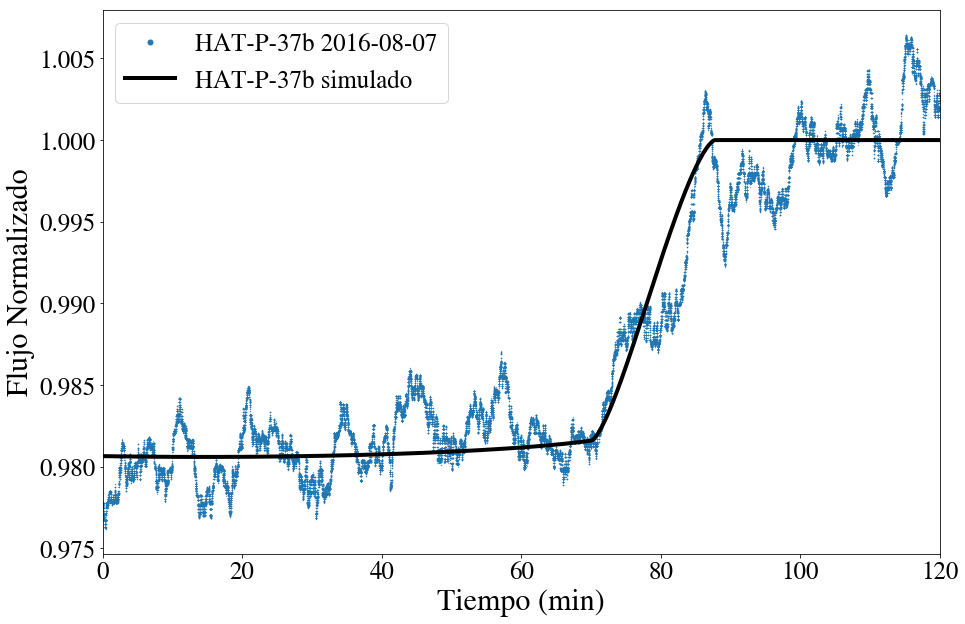

In [13]:
plt.figure(figsize=(15,10))
plt.plot(x_add,lcx_2_add-0.01,'.',markersize=0.5,label='HAT-P-37b 2016-08-07')
plt.plot(x_add,transito_2_add,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=30)
plt.ylabel('Flujo Normalizado',size=30)
plt.xticks(size=25)
plt.yticks(size=25)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_mov_2.png',dpi=300)

In [17]:
print("Coeficiente de correlacion mediana movil")
print(np.corrcoef(lcx_2_add.real,transito_2_add.real))

Coeficiente de correlacion mediana movil
[[1.         0.96268175]
 [0.96268175 1.        ]]


FOU

In [18]:
lcx_1_add=fourierfilter(lcx_1,0.002)
lcx_2_add=fourierfilter(lcx_2,0.002)
transito_1_add=fourierfilter(transito1,0.002)
transito_2_add=fourierfilter(transito2,0.002)

/home/fernando/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 120)

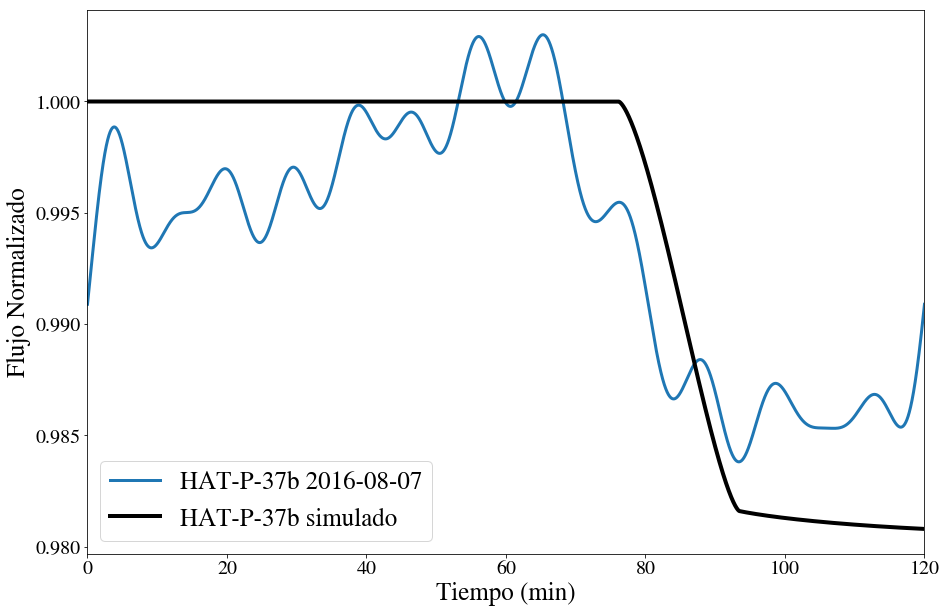

In [20]:
plt.figure(figsize=(15,10))
plt.plot(x,lcx_1_add-0.005,linewidth=3,label='HAT-P-37b 2016-08-07')
plt.plot(x,transito_1,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=25)
plt.ylabel('Flujo Normalizado',size=25)
plt.xticks(size=20)
plt.yticks(size=20)
leg= plt.legend(fontsize=25)
leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_fou_1.png',dpi=300)

/home/fernando/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 120)

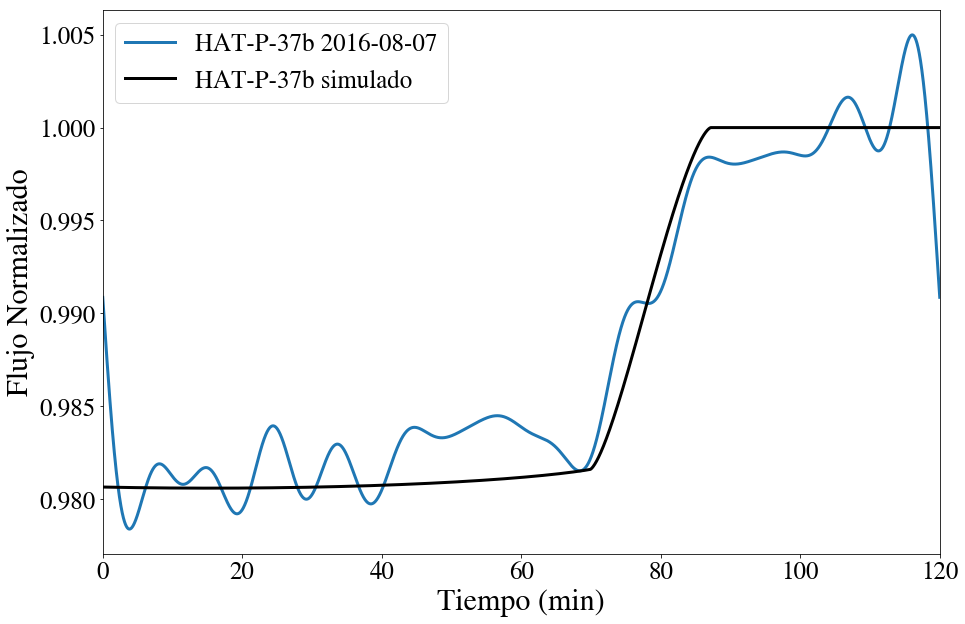

In [21]:
plt.figure(figsize=(15,10))
plt.plot(x,lcx_2_add-0.01,linewidth=3,label='HAT-P-37b 2016-08-07')
plt.plot(x,transito_2,'black',linewidth=3,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=30)
plt.ylabel('Flujo Normalizado',size=30)
plt.xticks(size=25)
plt.yticks(size=25)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_fou_2.png',dpi=300)

In [22]:
print("Coeficiente de correlación Fourier")
print(np.corrcoef(lcx_2_add.real,transito_2_add.real))

Coeficiente de correlación Fourier
[[1.         0.98269132]
 [0.98269132 1.        ]]


In [7]:
#####LEYENDO DATA PARA ENTRENAR PCA
f2=h5py.File('../data/train_pca_mandel_entradas.hdf5', 'r')
i=0
data_train=np.zeros((144000,len(f2.keys())))
for key in f2.keys():
    data_train[:,i] = np.array(f2[key])
    i=i+1
comp_entradas=pca_train(data_train)
comp_salidas=pca_train(data_train[::-1])
f2.close()

In [8]:
lcx_1_pca=pca_filter(lcx_1,comp_entradas)
lcx_2_pca=pca_filter(lcx_2,comp_salidas)

In [19]:
i

25

(0, 120)

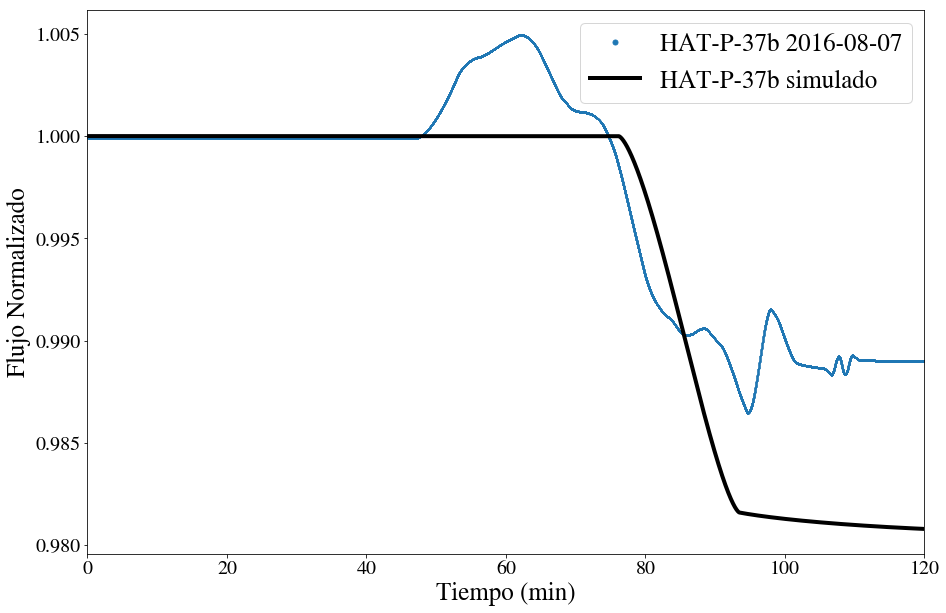

In [9]:
plt.figure(figsize=(15,10))
plt.plot(x,lcx_1_pca-0.0018,'.',markersize=0.5,label='HAT-P-37b 2016-08-07')
plt.plot(x,transito_1,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=25)
plt.ylabel('Flujo Normalizado',size=25)
plt.xticks(size=20)
plt.yticks(size=20)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_pca_1.png',dpi=300)

(0, 120)

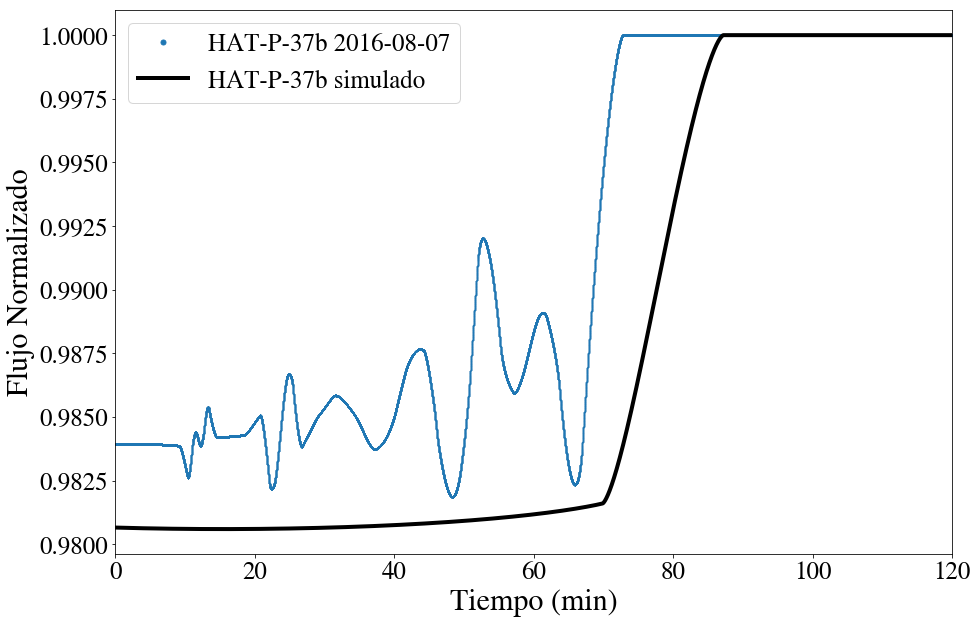

In [10]:
plt.figure(figsize=(15,10))
plt.plot(x,lcx_2_pca-0.0068,'.',markersize=0.5,label='HAT-P-37b 2016-08-07')
plt.plot(x,transito_2,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=30)
plt.ylabel('Flujo Normalizado',size=30)
plt.xticks(size=25)
plt.yticks(size=25)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_pca_2.png',dpi=300)

In [11]:
print("Coeficiente de correlación Fourier")
print(np.corrcoef(lcx_2_pca.real,transito_2_add.real))

Coeficiente de correlación Fourier


NameError: name 'transito_2_add' is not defined

In [12]:
ruido_r=ruido_real(11,1,4.09589900e+00, 15.55364026e-02, 20,8.90201637e-03,288000)

In [13]:
ruido_r = ruido_r[:144000]
lcx_2_pca=pca_filter(ruido_r,comp_salidas)

(0, 120)

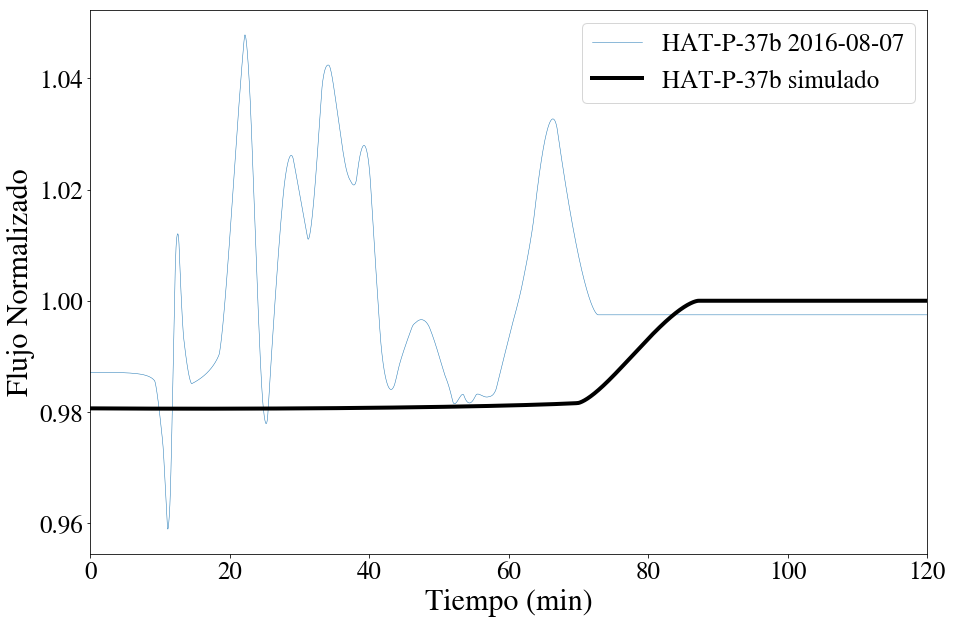

In [14]:
plt.figure(figsize=(15,10))
plt.plot(x,lcx_2_pca,linewidth=0.5,label='HAT-P-37b 2016-08-07')
plt.plot(x,transito_2,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo (min)',size=30)
plt.ylabel('Flujo Normalizado',size=30)
plt.xticks(size=25)
plt.yticks(size=25)
leg= plt.legend(fontsize=25)

leg.legendHandles[0]._legmarker.set_markersize(10)
plt.xlim(0,120)
#plt.savefig('../reports/figures/hat37b_pca_2.png',dpi=300)

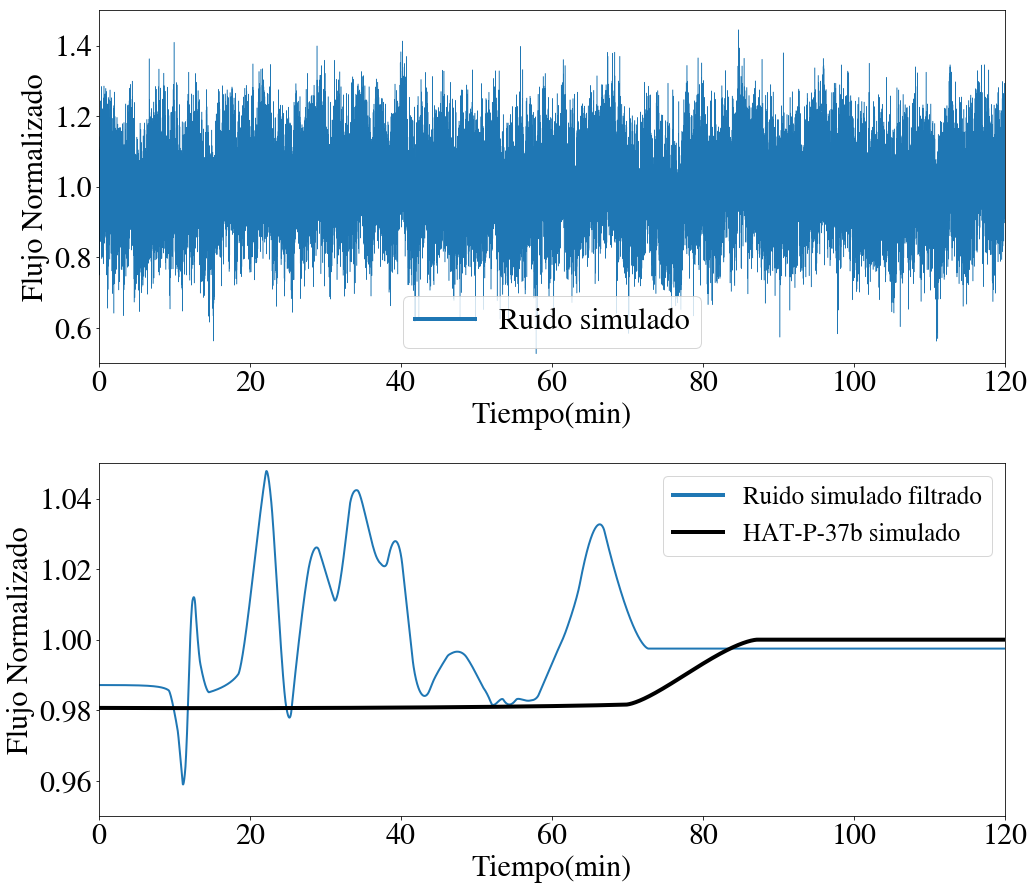

In [18]:
fig=plt.figure(figsize=(15,13))
plt.subplot(2, 1, 1)
plt.plot(x,ruido_r,linewidth=0.5,label='Ruido simulado')
plt.xlabel('Tiempo(min)',size=30)
plt.ylabel('Flujo Normalizado',size=30)
plt.xlim(0,120)
plt.ylim(0.5,1.5)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=30)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

plt.subplot(2, 1, 2)
plt.plot(x,lcx_2_pca,linewidth=2,label='Ruido simulado filtrado')
plt.plot(x,transito_2,'black',linewidth=4,label='HAT-P-37b simulado')
plt.xlabel('Tiempo(min)',size=30)
plt.ylabel('Flujo Normalizado',size=30)
plt.xlim(0,120)
plt.ylim(0.95,1.05)
plt.xticks(size=30)
plt.yticks(size=30)
leg= plt.legend(fontsize=25)

for line in leg.get_lines():
    line.set_linewidth(4.0) 

fig.tight_layout(pad=3.0)
plt.savefig('../reports/figures/PCA_puro_ruido.png',dpi=300)

In [5]:
parametros_trap=np.genfromtxt('../data/parametros_traps.txt',delimiter='_')

In [6]:
profundidades = parametros_trap[:,2]

In [7]:
profundidades_snr = []
for i in range (100):
    for k in range (625):
        profundidades_snr.append(profundidades[k])

# SNR 10

In [8]:
snr_mov,snr_fou,snr_pca = pickle.load(open('../data/SNR_calculadas_para_SNR=100.pickle', 'rb'))

In [9]:
df = {"profundidades":profundidades_snr ,"snr_mov":snr_mov,"snr_fou":snr_fou,"snr_pca":snr_pca}

In [10]:
resultados_snr = pd.DataFrame(df)

In [11]:
profundidades = resultados_snr.profundidades.unique()

In [12]:
profundidades

array([0.94 , 0.942, 0.945, 0.947, 0.95 , 0.952, 0.954, 0.957, 0.959,
       0.962, 0.964, 0.967, 0.969, 0.971, 0.974, 0.976, 0.979, 0.981,
       0.984, 0.986, 0.988, 0.991, 0.993, 0.996, 0.998])

In [13]:
profundidad_97=resultados_snr[resultados_snr.profundidades == 0.971]
profundidad_98=resultados_snr[resultados_snr.profundidades == 0.981]
profundidad_99=resultados_snr[resultados_snr.profundidades == 0.991]
profundidad_998=resultados_snr[resultados_snr.profundidades == 0.998]


In [14]:
len(profundidad_998)

2500

MOV

In [15]:
print("0.03 =", np.percentile(profundidad_97["snr_mov"],[5,50,95]))
print("0.02 =", np.percentile(profundidad_98["snr_mov"],[5,50,95]))
print("0.01 =", np.percentile(profundidad_99["snr_mov"],[5,50,95]))
print("0.002 =", np.percentile(profundidad_998["snr_mov"],[5,50,95]))

0.03 = [76.17012617 80.91346681 84.65270961]
0.02 = [108.68551067 120.85302177 128.06281426]
0.01 = [179.04713582 226.68455993 259.31120618]
0.002 = [256.13301365 438.9956773  936.26723944]


In [16]:
intervalo_97 = np.round_(np.percentile(profundidad_97["snr_mov"],[5,50,95]),2)
intervalo_98 = np.round_(np.percentile(profundidad_98["snr_mov"],[5,50,95]),2)
intervalo_99 = np.round_(np.percentile(profundidad_99["snr_mov"],[5,50,95]),2)
intervalo_998 = np.round_(np.percentile(profundidad_998["snr_mov"],[5,50,95]),2)

In [17]:
print(f"0.03 = ${{{intervalo_97[1]}}}_{{-{np.round(intervalo_97[1]-intervalo_97[0],2)}}}^{{+{np.round_(intervalo_97[2]-intervalo_97[1],2)}}}$")
print(f"0.02 = ${{{intervalo_98[1]}}}_{{-{np.round(intervalo_98[1]-intervalo_98[0],2)}}}^{{+{np.round_(intervalo_98[2]-intervalo_98[1],2)}}}$")
print(f"0.01 = ${{{intervalo_99[1]}}}_{{-{np.round(intervalo_99[1]-intervalo_99[0],2)}}}^{{+{np.round_(intervalo_99[2]-intervalo_99[1],2)}}}$")
print(f"0.002 = ${{{intervalo_998[1]}}}_{{-{np.round(intervalo_998[1]-intervalo_998[0],2)}}}^{{+{np.round_(intervalo_998[2]-intervalo_998[1],2)}}}$")

0.03 = ${80.91}_{-4.74}^{+3.74}$
0.02 = ${120.85}_{-12.16}^{+7.21}$
0.01 = ${226.68}_{-47.63}^{+32.63}$
0.002 = ${439.0}_{-182.87}^{+497.27}$


FOU

In [18]:
intervalo_97 = np.round_(np.percentile(profundidad_97["snr_fou"],[5,50,95]),2)
intervalo_98 = np.round_(np.percentile(profundidad_98["snr_fou"],[5,50,95]),2)
intervalo_99 = np.round_(np.percentile(profundidad_99["snr_fou"],[5,50,95]),2)
intervalo_998 = np.round_(np.percentile(profundidad_998["snr_fou"],[5,50,95]),2)

In [19]:
print(f"0.03 = ${{{intervalo_97[1]}}}_{{-{np.round(intervalo_97[1]-intervalo_97[0],2)}}}^{{+{np.round_(intervalo_97[2]-intervalo_97[1],2)}}}$")
print(f"0.02 = ${{{intervalo_98[1]}}}_{{-{np.round(intervalo_98[1]-intervalo_98[0],2)}}}^{{+{np.round_(intervalo_98[2]-intervalo_98[1],2)}}}$")
print(f"0.01 = ${{{intervalo_99[1]}}}_{{-{np.round(intervalo_99[1]-intervalo_99[0],2)}}}^{{+{np.round_(intervalo_99[2]-intervalo_99[1],2)}}}$")
print(f"0.002 = ${{{intervalo_998[1]}}}_{{-{np.round(intervalo_998[1]-intervalo_998[0],2)}}}^{{+{np.round_(intervalo_998[2]-intervalo_998[1],2)}}}$")

0.03 = ${81.71}_{-4.37}^{+4.01}$
0.02 = ${123.01}_{-10.47}^{+7.08}$
0.01 = ${240.81}_{-47.93}^{+24.17}$
0.002 = ${548.05}_{-237.59}^{+474.3}$


PCA

In [20]:
intervalo_97 = np.round_(np.percentile(profundidad_97["snr_pca"],[5,50,95]),2)
intervalo_98 = np.round_(np.percentile(profundidad_98["snr_pca"],[5,50,95]),2)
intervalo_99 = np.round_(np.percentile(profundidad_99["snr_pca"],[5,50,95]),2)
intervalo_998 = np.round_(np.percentile(profundidad_998["snr_pca"],[5,50,95]),2)

In [21]:
print(f"0.03 = ${{{intervalo_97[1]}}}_{{-{np.round(intervalo_97[1]-intervalo_97[0],2)}}}^{{+{np.round_(intervalo_97[2]-intervalo_97[1],2)}}}$")
print(f"0.02 = ${{{intervalo_98[1]}}}_{{-{np.round(intervalo_98[1]-intervalo_98[0],2)}}}^{{+{np.round_(intervalo_98[2]-intervalo_98[1],2)}}}$")
print(f"0.01 = ${{{intervalo_99[1]}}}_{{-{np.round(intervalo_99[1]-intervalo_99[0],2)}}}^{{+{np.round_(intervalo_99[2]-intervalo_99[1],2)}}}$")
print(f"0.002 = ${{{intervalo_998[1]}}}_{{-{np.round(intervalo_998[1]-intervalo_998[0],2)}}}^{{+{np.round_(intervalo_998[2]-intervalo_998[1],2)}}}$")

0.03 = ${81.22}_{-3.82}^{+4.11}$
0.02 = ${123.04}_{-8.96}^{+7.65}$
0.01 = ${248.12}_{-36.71}^{+27.47}$
0.002 = ${784.99}_{-357.55}^{+456.92}$


In [4]:
3/np.std([1,2,3,4,5])

2.1213203435596424